# WRF basic notebook

This notebook does some basic WRF comparisons *without* using LDCPY.

On NCAR's Jupyterhub, environment NPL 2024b is a good option.


In [1]:
# conda env:npl_2024b
import os

import cartopy
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xwrf
from cartopy import crs as ccrs

%matplotlib inline

To look at SPERR-compressed data, you need the HDF5 plugin installed and the path specified in HDF5_PLUGIN_PATH. So let's verify that.  (Note, I have all my plugins in the same zfp directory)

In [2]:
os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/abaker/compress-libs/zfp_plugin/plugin'

In [3]:
# Some CONUS 404 wrf data to look at (24 hourly sliced put into a single file)
# (wrf2d_d01_2020-07-01_00:00:00 => wrf2d_d01_2020-07-01_23:00:00 , and then for 3d also)
mydir = "/glade/campaign/cisl/asap/abaker/wrf/wrf_24hr_compare/"
file2d = "wrf2d_combined.nc"
file3d = "wrf3d_combined.nc"
# original data
o_file2d = mydir + "lossless/" + file2d
o_file3d = mydir + "lossless/" + file3d
# look at a granular bit rounded file w/3 sig figs
gbr_file2d = mydir + "gbr3/" + file2d
gbr_file3d = mydir + "gbr3/" + file3d
# look at a sperr file with pwe=1e-3
sp_file2d = mydir + "sperr_pwe1e-3/" + file2d
sp_file3d = mydir + "sperr_pwe1e-3/" + file3d

# this contains lat/lon info
fileconsts = mydir + "wrfconstants_usgs404.nc"

In [4]:
# open and process wrf files to work with properly with xarray
ds_o_2d = xr.open_dataset(o_file2d, engine="netcdf4").xwrf.postprocess()
ds_o_3d = xr.open_dataset(o_file3d, engine="netcdf4").xwrf.postprocess()

ds_gbr_2d = xr.open_dataset(gbr_file2d, engine="netcdf4").xwrf.postprocess()
ds_gbr_3d = xr.open_dataset(gbr_file3d, engine="netcdf4").xwrf.postprocess()

ds_sp_2d = xr.open_dataset(sp_file2d, engine="netcdf4").xwrf.postprocess()
ds_sp_3d = xr.open_dataset(sp_file3d, engine="netcdf4").xwrf.postprocess()

In [5]:
# lat and lon info is in the const file (unless you are using the wrf conus404 rda data, when you don't need this)
ds_const = xr.open_dataset(fileconsts, engine="netcdf4").xwrf.postprocess()

In [6]:
# what's in the file
ds_const.coords

Coordinates:
    XLAT     (y, x) float32 6MB ...
    XLONG    (y, x) float32 6MB ...
    XLAT_U   (y, x_stag) float32 6MB ...
    XLONG_U  (y, x_stag) float32 6MB ...
    XLAT_V   (y_stag, x) float32 6MB ...
    XLONG_V  (y_stag, x) float32 6MB ...
    XTIME    (Time) datetime64[ns] 8B 1979-10-01
  * z        (z) float32 200B 0.9969 0.9901 0.9821 ... 0.0161 0.009015 0.0028
  * z_stag   (z_stag) float32 204B 1.0 0.9938 0.9864 ... 0.01243 0.0056 0.0
  * Time     (Time) datetime64[ns] 8B 1979-10-01
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
  * y_stag   (y_stag) float64 8kB -2.03e+06 -2.026e+06 ... 2.026e+06 2.03e+06
  * x_stag   (x_stag) float64 11kB -2.734e+06 -2.73e+06 ... 2.73e+06 2.734e+06

In [7]:
# get the lat and lon from the coords
wrf_lon = ds_const.coords["XLONG"]
wrf_lat = ds_const.coords["XLAT"]
# for V vars
wrf_lon_v = ds_const.coords["XLONG_U"]
wrf_lat_v = ds_const.coords["XLAT_U"]
# for U vars
wrf_lon_u = ds_const.coords["XLONG_U"]
wrf_lat_u = ds_const.coords["XLAT_U"]

In [8]:
# To see all the vars and descriptions
for var in ds_o_2d:
    try:
        print(f'variable: {var}, description: {ds_o_2d[var].description}')
    except:
        pass

variable: TV, description: vegetation leaf temperature
variable: LAI, description: LEAF AREA INDEX
variable: Q2, description: QV at 2 M
variable: T2, description: TEMP at 2 M
variable: TH2, description: POT TEMP at 2 M
variable: PSFC, description: SFC PRESSURE
variable: U10, description: U at 10 M
variable: V10, description: V at 10 M
variable: TSLB, description: SOIL TEMPERATURE
variable: SMOIS, description: SOIL MOISTURE
variable: SH2O, description: SOIL LIQUID WATER
variable: SEAICE, description: SEA ICE FLAG
variable: ACSNOM, description: ACCUMULATED MELTED SNOW
variable: SNOW, description: SNOW WATER EQUIVALENT
variable: SNOWH, description: PHYSICAL SNOW DEPTH
variable: CANWAT, description: CANOPY WATER
variable: SSTSK, description: SKIN SEA SURFACE TEMPERATURE
variable: COSZEN, description: COS of SOLAR ZENITH ANGLE
variable: TSK, description: SURFACE SKIN TEMPERATURE
variable: RAINNCV, description: TIME-STEP NONCONVECTIVE PRECIPITATION
variable: SWDOWN, description: DOWNWARD SHO

In [9]:
# grab var of interest at time=0 for 2D
var = "Q2"
o_var = ds_o_2d[var].isel(Time=0)
gbr_var = ds_gbr_2d[var].isel(Time=0)
sp_var = ds_sp_2d[var].isel(Time=0)

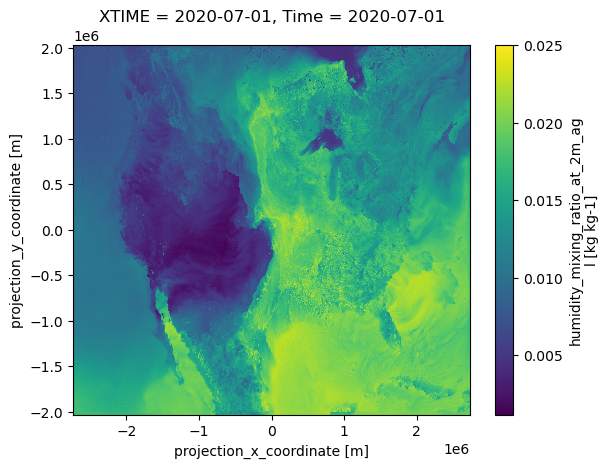

In [10]:
# basic xarray quick plot of original data
# (note: lat and lon not in the file)

o_var.plot()

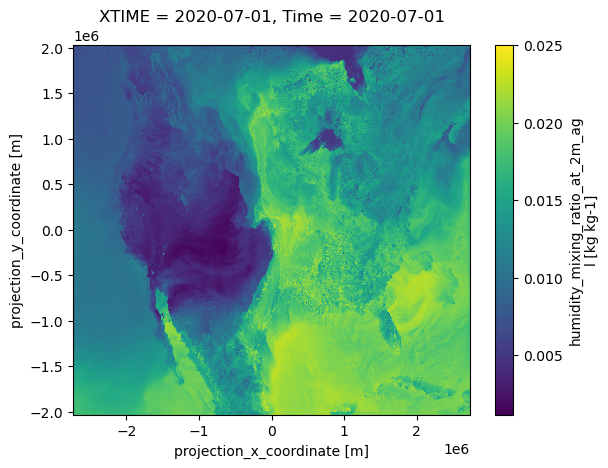

In [11]:
# compressed with GBR
gbr_var.plot()

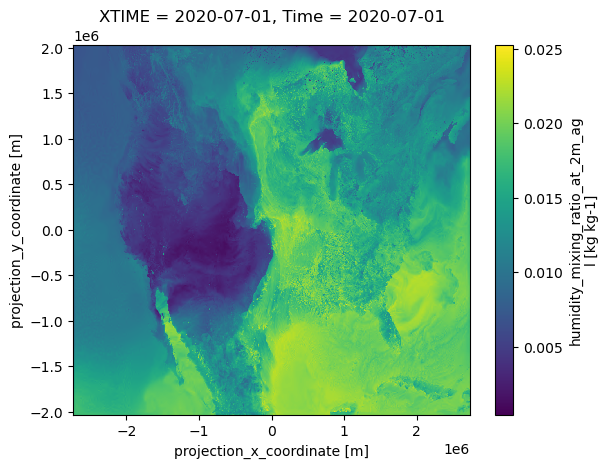

In [12]:
# compressed with sperr
sp_var.plot()

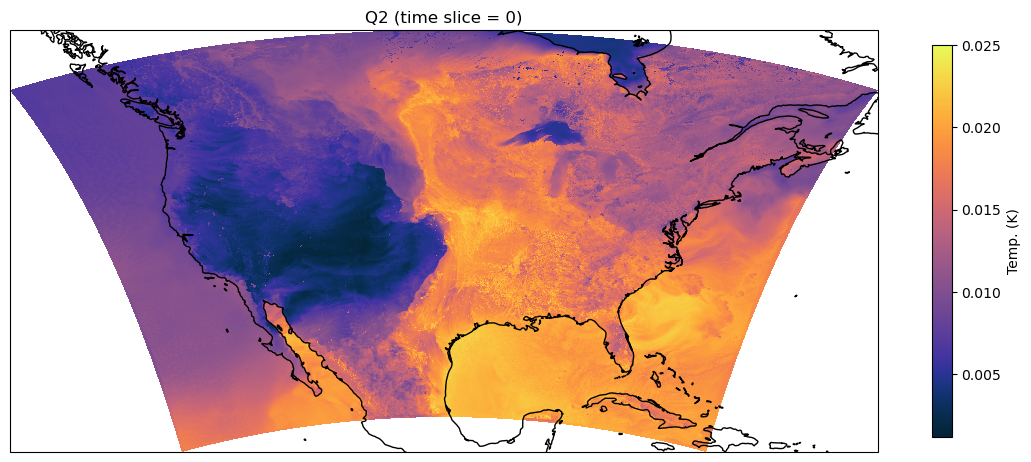

In [13]:
# a bit fancier: incorporate correct projection as well as lat/lon info
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

mymap = cmocean.cm.thermal
tt = ax.pcolormesh(wrf_lon, wrf_lat, o_var.data, cmap=mymap)
ax.set_title(var + " (time slice = 0)")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="Temp. (K)")
plt.show()

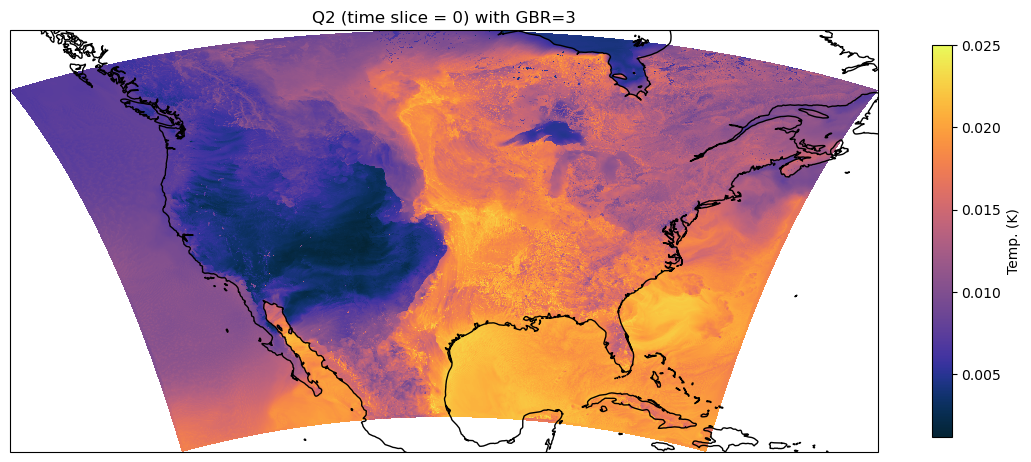

In [14]:
# incorporate correct projection as well as lat/lon info - GBR
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = cmocean.cm.thermal
tt = ax.pcolormesh(wrf_lon, wrf_lat, gbr_var.data, cmap=mymap)
ax.set_title(var + " (time slice = 0) with GBR=3")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="Temp. (K)")
plt.show()

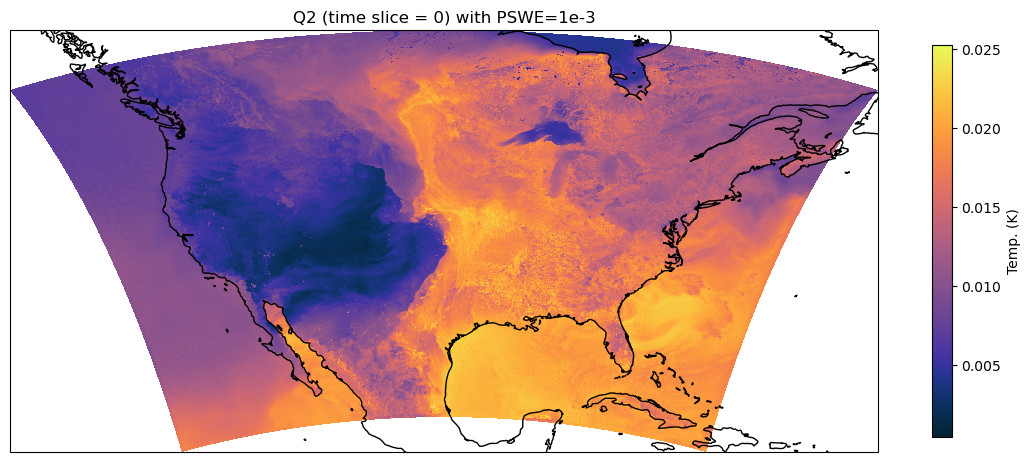

In [15]:
# incorporate correct projection as well as lat/lon info - SPERR p100
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = cmocean.cm.thermal
tt = ax.pcolormesh(wrf_lon, wrf_lat, sp_var.data, cmap=mymap)
ax.set_title(var + " (time slice = 0) with PSWE=1e-3")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="Temp. (K)")
plt.show()

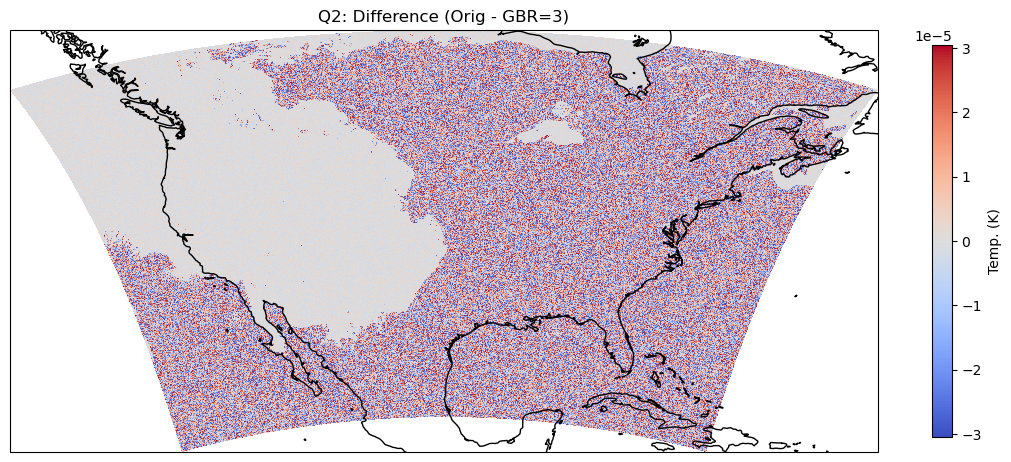

In [16]:
# plot the difference -GBR
diff_var = o_var.data - gbr_var.data
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = "coolwarm"
tt = ax.pcolormesh(wrf_lon, wrf_lat, diff_var, cmap=mymap)
ax.set_title(var + ": Difference (Orig - GBR=3)")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="Temp. (K)")
plt.show()

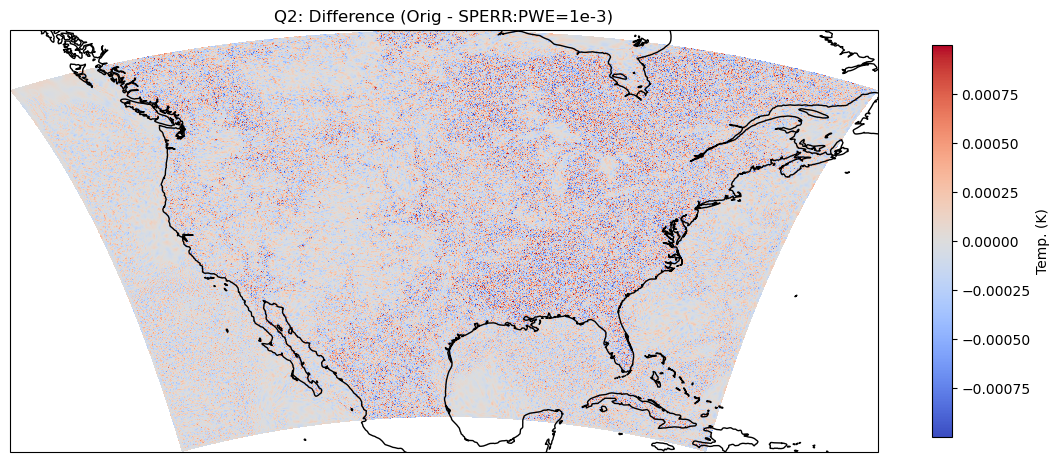

In [17]:
# plot the difference - sperr
sperr_diff_var = o_var.data - sp_var.data
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = "coolwarm"
tt = ax.pcolormesh(wrf_lon, wrf_lat, sperr_diff_var, cmap=mymap)
ax.set_title(var + ": Difference (Orig - SPERR:PWE=1e-3)")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="Temp. (K)")
plt.show()

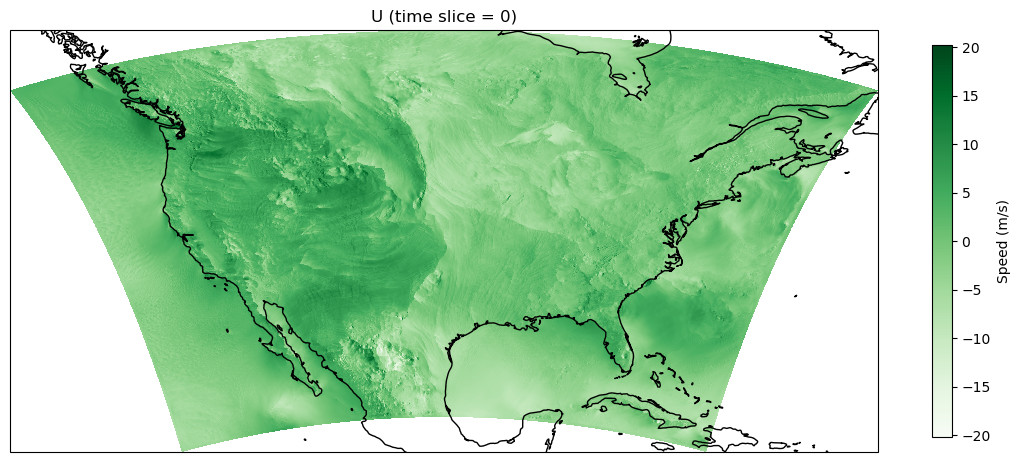

In [18]:
# if look at U or V, need different lat/lon values
# let's look at U
o_u = ds_o_2d["U"].isel(Time=0)
gbr_u = ds_gbr_2d["U"].isel(Time=0)
sp_u = ds_sp_2d["U"].isel(Time=0)

fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = "Greens"
tt = ax.pcolormesh(wrf_lon_u, wrf_lat_u, o_u.data, cmap=mymap)
ax.set_title("U (time slice = 0)")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="Speed (m/s)")
plt.show()

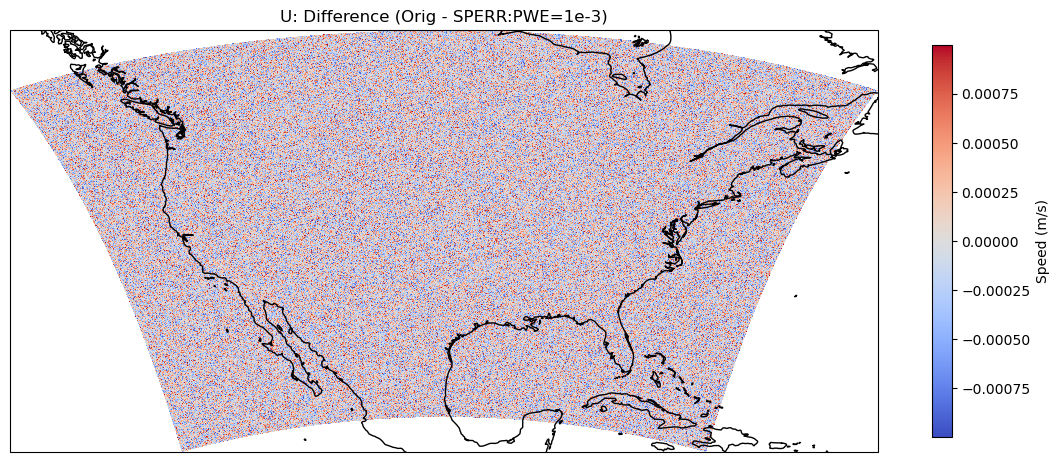

In [19]:
# plot the difference for u (w/SPERR)
sp_diff_u = o_u.data - sp_u.data
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = "coolwarm"
tt = ax.pcolormesh(wrf_lon_u, wrf_lat_u, sp_diff_u, cmap=mymap)
ax.set_title("U: Difference (Orig - SPERR:PWE=1e-3)")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="Speed (m/s)")
plt.show()

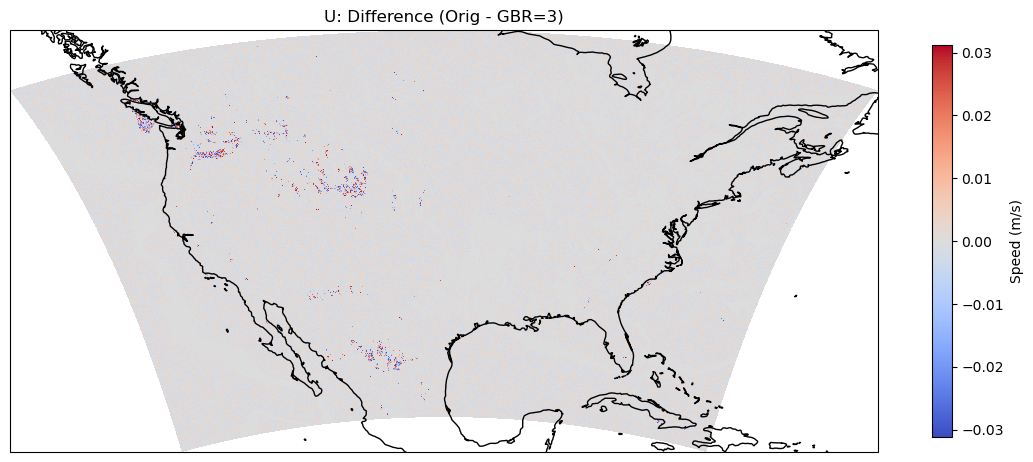

In [20]:
# plot the difference for u (GBR)
diff_u = o_u.data - gbr_u.data
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = "coolwarm"
tt = ax.pcolormesh(wrf_lon_u, wrf_lat_u, diff_u, cmap=mymap)
ax.set_title("U: Difference (Orig - GBR=3)")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="Speed (m/s)")
plt.show()

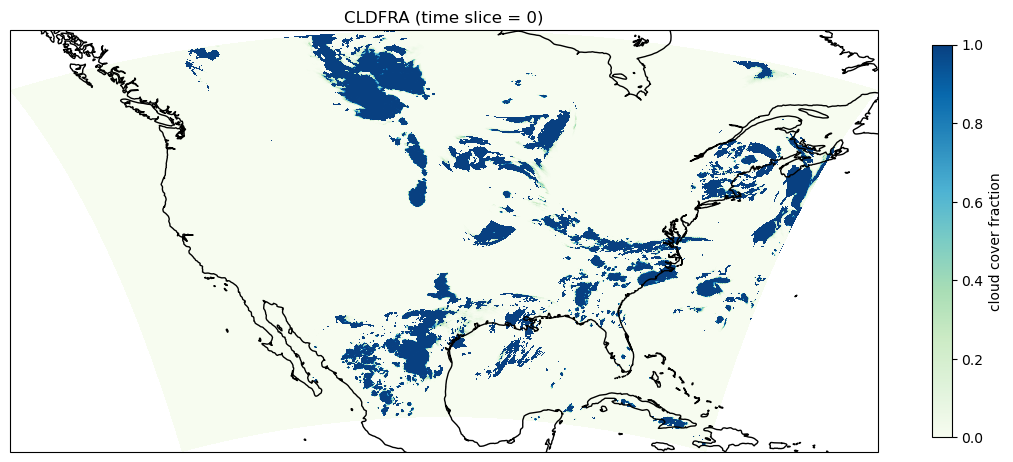

In [22]:
# now do a 3d field - can just look at a single level (there are 50 levels)
# here we did level 30
cld_slice = ds_o_3d["CLDFRA"].isel(Time=0).isel(z=30)

fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = "GnBu"
tt = ax.pcolormesh(wrf_lon, wrf_lat, cld_slice.data, cmap=mymap)
ax.set_title("CLDFRA (time slice = 0)")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="cloud cover fraction")
plt.show()

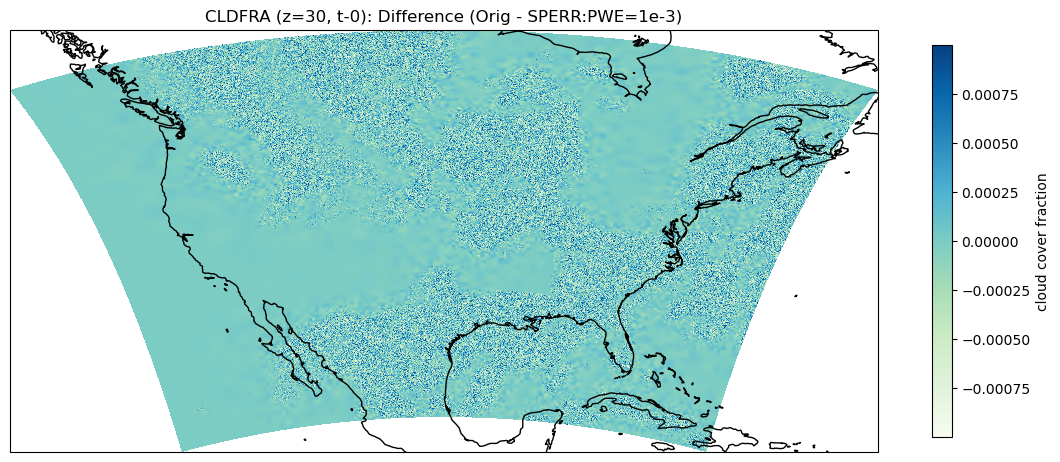

In [26]:
# 3D field: here we did level 30
# look at the difference from a compressed one

sp_cloud_slice = ds_sp_3d["CLDFRA"].isel(Time=0).isel(z=30)
sp_diff_3d = cld_slice - sp_cloud_slice

fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
mymap = "GnBu"
tt = ax.pcolormesh(wrf_lon, wrf_lat, sp_diff_3d.data, cmap=mymap)
ax.set_title("CLDFRA (z=30, t-0): Difference (Orig - SPERR:PWE=1e-3)")
ax.coastlines()
fig.colorbar(tt, shrink=0.85, label="cloud cover fraction")
plt.show()